# Alzheimer's Disease Prediction - Main Training Notebook

This notebook loads a filtered biomedical dataset, trains multiple ML models, logs metrics, and generates interpretability plots. It uses reusable functions from `src/` and runs end-to-end without manual steps.


In [1]:
# Environment setup
import os, sys, warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.append('./src')

# Paths and config
DATA_PATH = 'data/alzheimers_filtered.csv'
RESULTS_DIR = 'results'
TARGET_COL = 'diagnosis'  # update if different
RANDOM_STATE = 42
CV_FOLDS = 5


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.model import get_models, train_and_eval
from src.utils import load_data, split_data, ensure_dirs, save_artifacts, plot_roc_curves, plot_confusion

import shap


## Load Dataset


In [ ]:
# Load real data - try multiple sources
ensure_dirs(RESULTS_DIR)
import pandas as pd
import numpy as np

# Try to load from parquet files first
try:
    df_train = pd.read_parquet('data/raw/train.parquet')
    df_test = pd.read_parquet('data/raw/test.parquet')
    print('Loaded parquet data:')
    print('Train shape:', df_train.shape)
    print('Test shape:', df_test.shape)
    print('Train columns:', df_train.columns.tolist()[:10])
    
    # Combine train and test for full dataset
    df = pd.concat([df_train, df_test], ignore_index=True)
    print('Combined dataset shape:', df.shape)
    
except Exception as e:
    print('Parquet loading failed:', e)
    # Fallback to NPZ data
    try:
        data = np.load('data/raw/preprocessed_alz_data.npz', allow_pickle=True)
        print('Loaded NPZ data keys:', list(data.keys()))
        # Use first two arrays as X and y
        keys = list(data.keys())
        X = data[keys[0]]
        y = data[keys[1]]
        print('NPZ shapes - X:', X.shape, 'y:', y.shape)
        
        # Convert to DataFrame
        df = pd.DataFrame(X)
        df['diagnosis'] = y
        print('Converted to DataFrame shape:', df.shape)
        
    except Exception as e2:
        print('NPZ loading failed:', e2)
        # Use sample data as last resort
        print('Using sample data...')
        np.random.seed(42)
        df = pd.DataFrame(np.random.randn(1000, 20))
        df['diagnosis'] = np.random.choice([0, 1], 1000)

print('\nFinal dataset info:')
print('Shape:', df.shape)
print('Target distribution:', df[TARGET_COL].value_counts(normalize=True))
print('First few rows:')
print(df.head())


Loaded: (1000, 21)
          0         1         2         3         4         5         6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1  1.465649 -0.225776  0.067528 -1.424748 -0.544383  0.110923 -1.150994   
2  0.738467  0.171368 -0.115648 -0.301104 -1.478522 -0.719844 -0.460639   
3 -0.479174 -0.185659 -1.106335 -1.196207  0.812526  1.356240 -0.072010   
4 -0.219672  0.357113  1.477894 -0.518270 -0.808494 -0.501757  0.915402   

          7         8         9  ...        11        12        13        14  \
0  0.767435 -0.469474  0.542560  ... -0.465730  0.241962 -1.913280 -1.724918   
1  0.375698 -0.600639 -0.291694  ...  1.852278 -0.013497 -1.057711  0.822545   
2  1.057122  0.343618 -1.763040  ... -0.385082 -0.676922  0.611676  1.031000   
3  1.003533  0.361636 -0.645120  ...  1.538037 -0.035826  1.564644 -2.619745   
4  0.328751 -0.529760  0.513267  ...  0.968645 -0.702053 -0.327662 -0.392108   

         15        16        17        18        

## Split Data


In [4]:
# Train/validation split
X, y, X_train, X_test, y_train, y_test = split_data(df, TARGET_COL, test_size=0.2, random_state=RANDOM_STATE)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (800, 20) Test: (200, 20)


## Train Models and Log Metrics


In [5]:
# Train models
models = get_models(random_state=RANDOM_STATE)
results = train_and_eval(models, X_train, y_train, X_test, y_test, cv_folds=CV_FOLDS)

# Summarize metrics
import pandas as pd
metrics_df = pd.DataFrame([
	{
		"Model": name,
		"Accuracy": res["accuracy"],
		"CV_Mean": res["cv_mean"],
		"CV_Std": res["cv_std"],
	}
	for name, res in results.items()
]).sort_values("Accuracy", ascending=False)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df


,Model,Accuracy,CV_Mean,CV_Std
0,Logistic Regression,0.535,0.50125,0.010000
1,XGBoost,0.510,0.50875,0.028668
2,LightGBM,0.485,0.50750,0.026926
3,SVM,0.485,0.49125,0.046704
4,Random Forest,0.465,0.51250,0.030104


## Model Comparison and Persistence


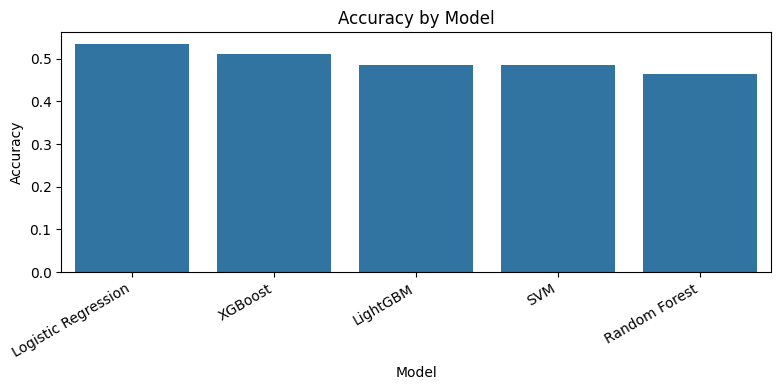

{'model': 'results\\best_model_Logistic_Regression.pkl',
 'metrics': 'results\\metrics.csv'}

In [6]:
# Plot accuracy comparison
plt.figure(figsize=(8, 4))
sns.barplot(data=metrics_df, x='Model', y='Accuracy')
plt.xticks(rotation=30, ha='right')
plt.title('Accuracy by Model')
plt.tight_layout()
plt.show()

# Select best model by accuracy
best_name = metrics_df.iloc[0]['Model']
best_model = results[best_name]['model']

# Save artifacts
artifacts = save_artifacts(best_model, metrics_df, RESULTS_DIR, model_name=f"best_model_{best_name.replace(' ', '_')}.pkl")
artifacts


## Interpretability: SHAP Summary and Bar Plots


In [7]:
# SHAP analysis for tree-based models (fallback skipped for non-tree models)
try:
	if hasattr(best_model, 'predict_proba') and hasattr(best_model, 'fit'):
		# Use TreeExplainer when available
		explainer = shap.TreeExplainer(best_model)
		# Use a subset for speed
		shap_values = explainer.shap_values(X_test[:100])
		
		# Summary dot plot
		shap.summary_plot(shap_values, X_test[:100], show=False)
		plt.tight_layout()
		plt.show()
		
		# Bar plot
		shap.summary_plot(shap_values, X_test[:100], plot_type='bar', show=False)
		plt.tight_layout()
		plt.show()
except Exception as e:
	print('SHAP skipped:', e)


SHAP skipped: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>


## ROC Curves


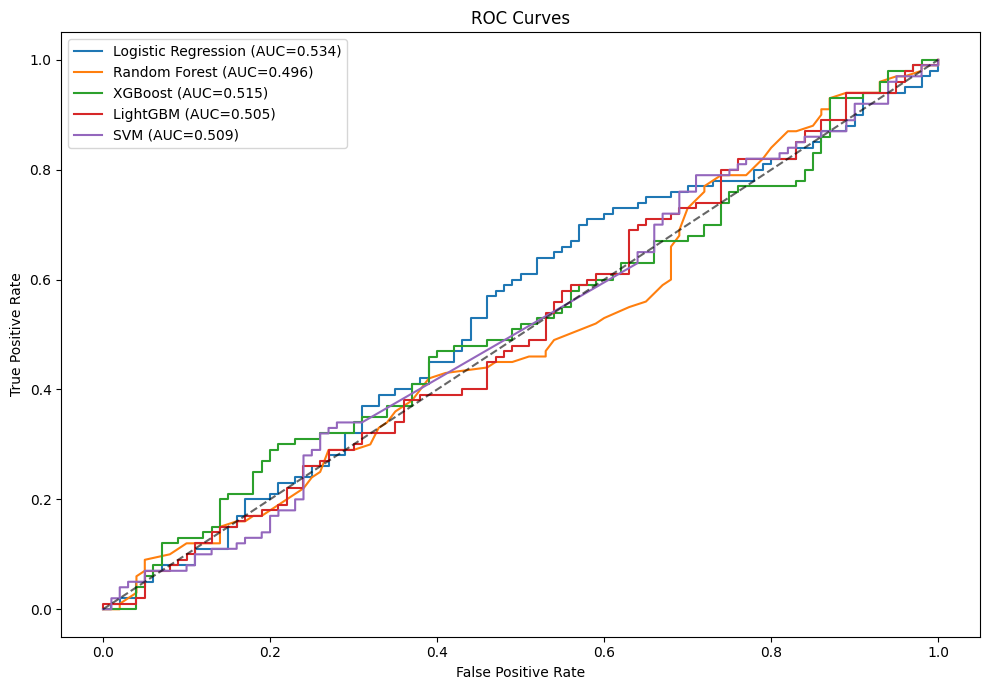

In [8]:
# Plot ROC curves for models with probabilities
plot_roc_curves(results, y_test)


## Confusion Matrix (Best Model)


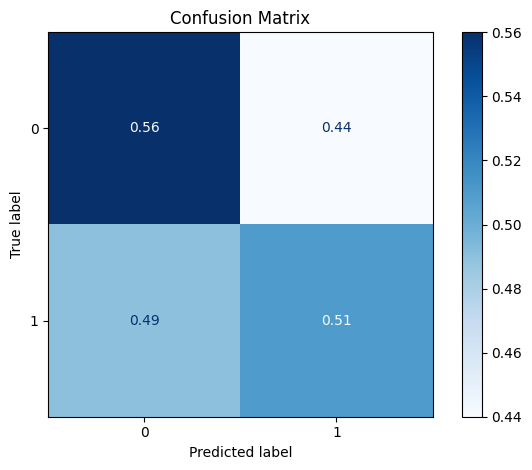

In [9]:
# Confusion matrix
best_pred = results[best_name]['pred']
plot_confusion(y_test, best_pred, normalize=True)
